# Data Import

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from geopy.distance import geodesic

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go

In [2]:
dataset_path = '/kaggle/input/sncb-data-augumentation/enriched_cleaned_ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")
    
data = data.drop(['Unnamed: 0', 'dayofweek', 'datetime', 'date_hour'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677337 entries, 0 to 17677336
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   timestamps_UTC      object 
 2   mapped_veh_id       float64
 3   lat                 float64
 4   lon                 float64
 5   RS_E_InAirTemp_PC1  float64
 6   RS_E_InAirTemp_PC2  float64
 7   RS_E_OilPress_PC1   float64
 8   RS_E_OilPress_PC2   float64
 9   RS_E_RPM_PC1        float64
 10  RS_E_RPM_PC2        float64
 11  RS_E_WatTemp_PC1    float64
 12  RS_E_WatTemp_PC2    float64
 13  RS_T_OilTemp_PC1    float64
 14  RS_T_OilTemp_PC2    float64
 15  date                object 
 16  hour                float64
 17  dayofweek           float64
 18  weekday             object 
 19  Distance            float64
 20  Speed               float64
 21  date_hour           object 
 22  datetime            object 
 23  weather_main        object 
 24  temp                fl

# Statistical methods to Label

In [3]:
stopped_threshold = 10  
minimum_stopped_minutes = 30  

In [4]:
# Convert timestamps to datetime and sort
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])
data = data.sort_values('timestamps_UTC')

# Calculate time differences in minutes
data['time_diff'] = data['timestamps_UTC'].diff().dt.total_seconds() / 60.0

# Identify rows where the vehicle is stopped
data['is_stopped'] = data['Speed'] < stopped_threshold

# Forward-fill the 'is_stopped' status only within the groups where the vehicle is stopped
data['stopped_group'] = data['is_stopped'].ne(data['is_stopped'].shift()).cumsum()
data.loc[data['is_stopped'], 'stopped_group'] = data.loc[data['is_stopped'], 'stopped_group']

# Calculate the cumulative stopped time in minutes only for stopped groups
data['cumulative_stopped_time'] = data.groupby('stopped_group')['time_diff'].cumsum().fillna(0)

# Determine the stopped groups that exceed the minimum stopped duration
stopped_groups = data[data['cumulative_stopped_time'] > minimum_stopped_minutes]['stopped_group'].unique()

# Mark the status based on the identified stopped groups
data['status'] = 'running'
data.loc[data['stopped_group'].isin(stopped_groups), 'status'] = 'stopped'


In [5]:
data

,timestamps_UTC,mapped_veh_id,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,...,humidity,wind,clouds,temp_celsius,feels_like_celsius,time_diff,is_stopped,stopped_group,cumulative_stopped_time,status
10309566,2023-01-23 02:29:50,160.0,51.04,3.69,14.0,15.0,6.0,27.0,802.0,804.0,...,90.0,2.62,100.0,1.34,-1.55,NaN,True,1,0.000000,stopped
10309567,2023-01-23 02:30:49,160.0,51.04,3.69,14.0,25.0,6.0,24.0,802.0,804.0,...,92.0,2.65,100.0,1.42,-1.48,0.983333,True,1,0.983333,stopped
10309568,2023-01-23 02:31:50,160.0,51.04,3.69,20.0,30.0,6.0,24.0,802.0,804.0,...,92.0,2.65,100.0,1.42,-1.48,1.016667,True,1,2.000000,stopped
479843,2023-01-23 02:50:41,106.0,50.41,4.52,41.0,41.0,6.0,3.0,802.0,804.0,...,99.0,3.60,75.0,0.03,-3.96,18.850000,True,1,20.850000,stopped
479844,2023-01-23 02:50:48,106.0,50.41,4.52,41.0,41.0,3.0,3.0,802.0,804.0,...,99.0,3.60,75.0,0.03,-3.96,0.116667,True,1,20.966667,stopped
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319481,2023-09-13 21:51:55,115.0,50.14,4.50,38.0,36.0,182.0,213.0,802.0,800.0,...,88.0,1.03,75.0,13.68,13.40,0.550000,True,15297,24.583333,running
16731733,2023-09-13 21:51:57,191.0,51.15,4.61,36.0,37.0,424.0,420.0,1501.0,1500.0,...,84.0,1.03,100.0,13.70,13.32,0.033333,True,15297,24.616667,running
3190108,2023-09-13 21:52:16,120.0,50.15,4.50,37.0,31.0,196.0,241.0,801.0,797.0,...,88.0,1.03,75.0,13.68,13.40,0.316667,True,15297,24.933333,running
17418908,2023-09-13 21:52:22,196.0,50.42,4.54,18.0,23.0,690.0,300.0,800.0,795.0,...,92.0,2.57,20.0,14.30,14.19,0.100000,True,15297,25.033333,running


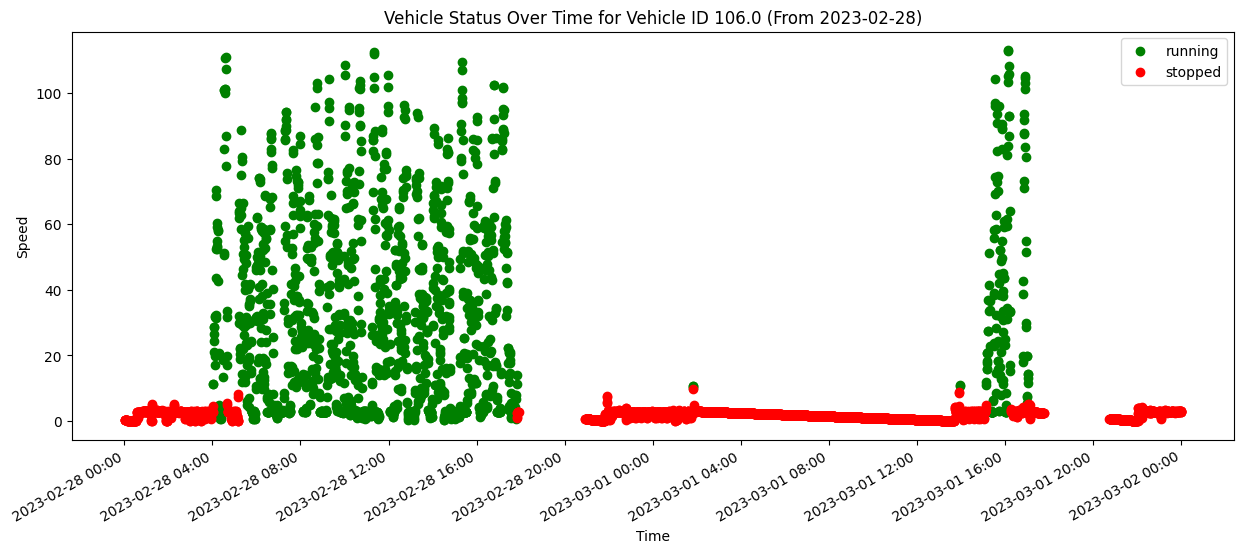

In [6]:
# Define the threshold for a vehicle being stopped and the duration
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

# Select a specific vehicle ID
specific_veh_id = data['mapped_veh_id'].unique()[1]  
veh_data = data[data['mapped_veh_id'] == specific_veh_id]

# Define the start and end dates for the week you want to display
week_start = pd.to_datetime("2023-02-28")  # Example start date
week_end = week_start + pd.Timedelta(days=2)  # Two days later

# Filter the data for that period
week_data = veh_data[(veh_data['timestamps_UTC'] >= week_start) & (veh_data['timestamps_UTC'] < week_end)]

# Create the plot
plt.figure(figsize=(15, 6))

# Use different colors for running and stopped status
for status, color in [('running', 'green'), ('stopped', 'red')]:
    status_data = week_data[week_data['status'] == status]
    plt.scatter(status_data['timestamps_UTC'], status_data['Speed'], color=color, label=status)

# Set the legend
plt.legend()

# Set the chart title and axis labels
plt.title(f"Vehicle Status Over Time for Vehicle ID {specific_veh_id} (From {week_start.strftime('%Y-%m-%d')})")
plt.xlabel("Time")
plt.ylabel("Speed")

# Format the x-axis to better display dates and times
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.gcf().autofmt_xdate()  # Automatically rotate date labels to prevent overlap

# Show the plot
plt.show()

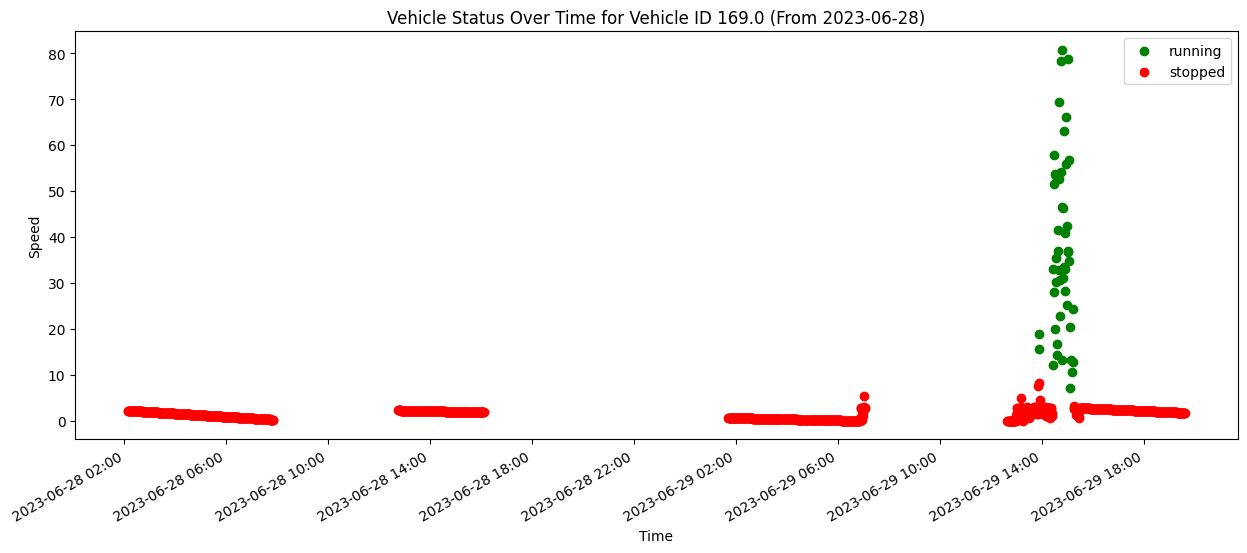

In [7]:
# Define the threshold for a vehicle being stopped and the duration
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

# Select a specific vehicle ID
specific_veh_id = data['mapped_veh_id'].unique()[50] 
veh_data = data[data['mapped_veh_id'] == specific_veh_id]

# Define the start and end dates for the week you want to display
week_start = pd.to_datetime("2023-06-28")  # Example start date
week_end = week_start + pd.Timedelta(days=2)  # Two days later

# Filter the data for that period
week_data = veh_data[(veh_data['timestamps_UTC'] >= week_start) & (veh_data['timestamps_UTC'] < week_end)]

# Create the plot
plt.figure(figsize=(15, 6))

# Use different colors for running and stopped status
for status, color in [('running', 'green'), ('stopped', 'red')]:
    status_data = week_data[week_data['status'] == status]
    plt.scatter(status_data['timestamps_UTC'], status_data['Speed'], color=color, label=status)

# Set the legend
plt.legend()

# Set the chart title and axis labels
plt.title(f"Vehicle Status Over Time for Vehicle ID {specific_veh_id} (From {week_start.strftime('%Y-%m-%d')})")
plt.xlabel("Time")
plt.ylabel("Speed")

# Format the x-axis to better display dates and times
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.gcf().autofmt_xdate()  # Automatically rotate date labels to prevent overlap

# Show the plot
plt.show()

# Label about Stoped or Running

In [8]:
# # Change the value in data[hout] to better clustering
# data['hour'] = data['hour'].replace(22, -2)
# data['hour'] = data['hour'].replace(23, -1)

# data['RPM_Mean'] = data[['RS_E_RPM_PC1', 'RS_E_RPM_PC2']].mean(axis=1)

# # Selecting the relevant columns for clustering
# clustering_data = data[['Speed', 'RPM_Mean', 'hour']]  # Make sure to use 'RS_E_RPM_PC2' for the second RPM

# # Removing rows with NaN values
# clustering_data_cleaned = clustering_data.dropna()

# # Normalize the data
# scaler = StandardScaler()
# clustering_data_scaled = scaler.fit_transform(clustering_data_cleaned)

# # Increase the weight of 'hour' and 'Speed' by multiplying them by a factor, let's say 2
# weight_factor = 1
# clustering_data_scaled[:, 0] *= 1 * weight_factor  # Speed
# clustering_data_scaled[:, 2] *= 1 * weight_factor  # hour

# # Applying K-Means Clustering
# kmeans = KMeans(n_clusters=2, random_state=0)
# clusters = kmeans.fit_predict(clustering_data_scaled)

# # Adding the cluster labels to the original data for analysis
# # Make sure 'data_parsed' is a copy of your original dataframe to add the clusters to
# data_parsed = data.copy()
# data_parsed = data_parsed.loc[clustering_data_cleaned.index]  # Align the indices
# data_parsed['running'] = clusters

# # Displaying the first few rows of the dataset with cluster labels
# data_parsed.head()

In [9]:
def apply_minibatch_kmeans(subset, n_clusters=2):
    scaler = StandardScaler()
    subset_scaled = scaler.fit_transform(subset)
    
    mbkmeans = MiniBatchKMeans(n_clusters=n_clusters)
    clusters = mbkmeans.fit_predict(subset_scaled)
    return clusters, mbkmeans.cluster_centers_

In [10]:
# Change the value in data[hout] to better clustering
data['hour'] = data['hour'].replace(22, -2)
data['hour'] = data['hour'].replace(23, -1)

data['RPM_Mean'] = data[['RS_E_RPM_PC1', 'RS_E_RPM_PC2']].mean(axis=1)

cluster_results = {}

for veh_id in data['mapped_veh_id'].unique():
    subset = data[data['mapped_veh_id'] == veh_id][['Speed', 'RPM_Mean', 'hour']].dropna()
    cluster_labels, cluster_centers = apply_minibatch_kmeans(subset, n_clusters=2)
    cluster_results[veh_id] = {
        'labels': cluster_labels,
        'centers': cluster_centers
    }

    data.loc[subset.index, 'cluster'] = cluster_labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: 

# Visualize Runing Lable

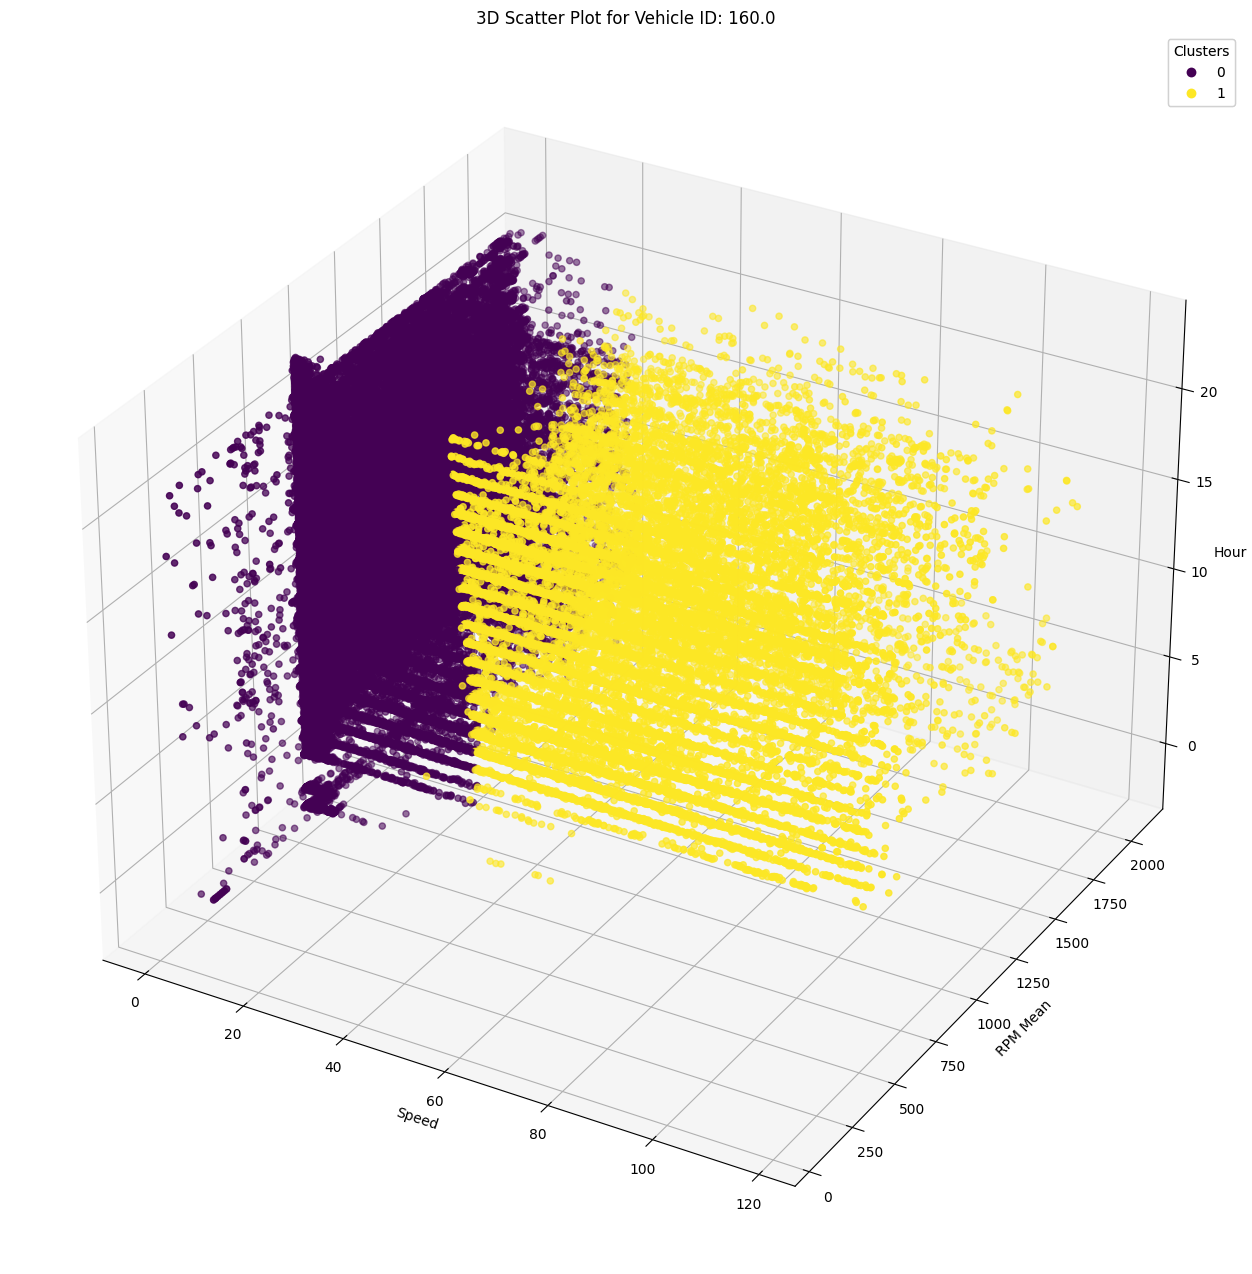

In [11]:
veh_id_to_plot = data['mapped_veh_id'].unique()[0]
data_to_plot = data[data['mapped_veh_id'] == veh_id_to_plot]

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_to_plot['Speed'], data_to_plot['RPM_Mean'], data_to_plot['hour'], 
                     c=data_to_plot['cluster'], cmap='viridis', depthshade=True)

legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)

ax.set_xlabel('Speed')
ax.set_ylabel('RPM Mean')
ax.set_zlabel('Hour')

ax.set_title('3D Scatter Plot for Vehicle ID: {}'.format(veh_id_to_plot))

plt.show()

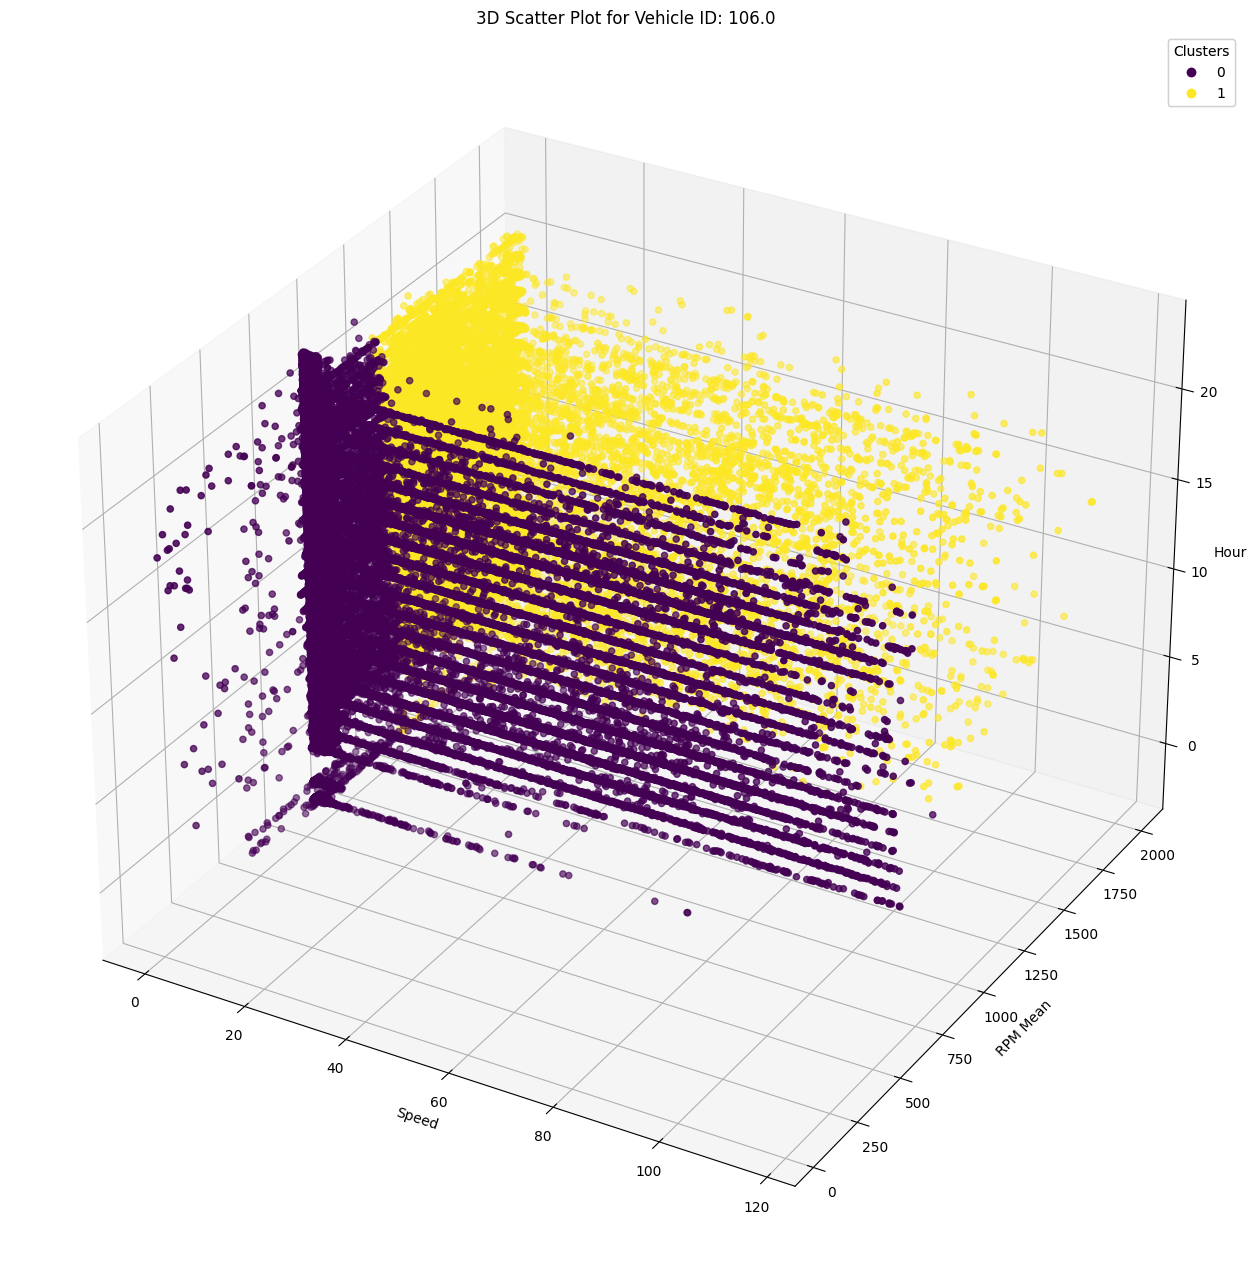

In [12]:
veh_id_to_plot = data['mapped_veh_id'].unique()[1]
data_to_plot = data[data['mapped_veh_id'] == veh_id_to_plot]

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_to_plot['Speed'], data_to_plot['RPM_Mean'], data_to_plot['hour'], 
                     c=data_to_plot['cluster'], cmap='viridis', depthshade=True)

legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)

ax.set_xlabel('Speed')
ax.set_ylabel('RPM Mean')
ax.set_zlabel('Hour')

ax.set_title('3D Scatter Plot for Vehicle ID: {}'.format(veh_id_to_plot))

plt.show()

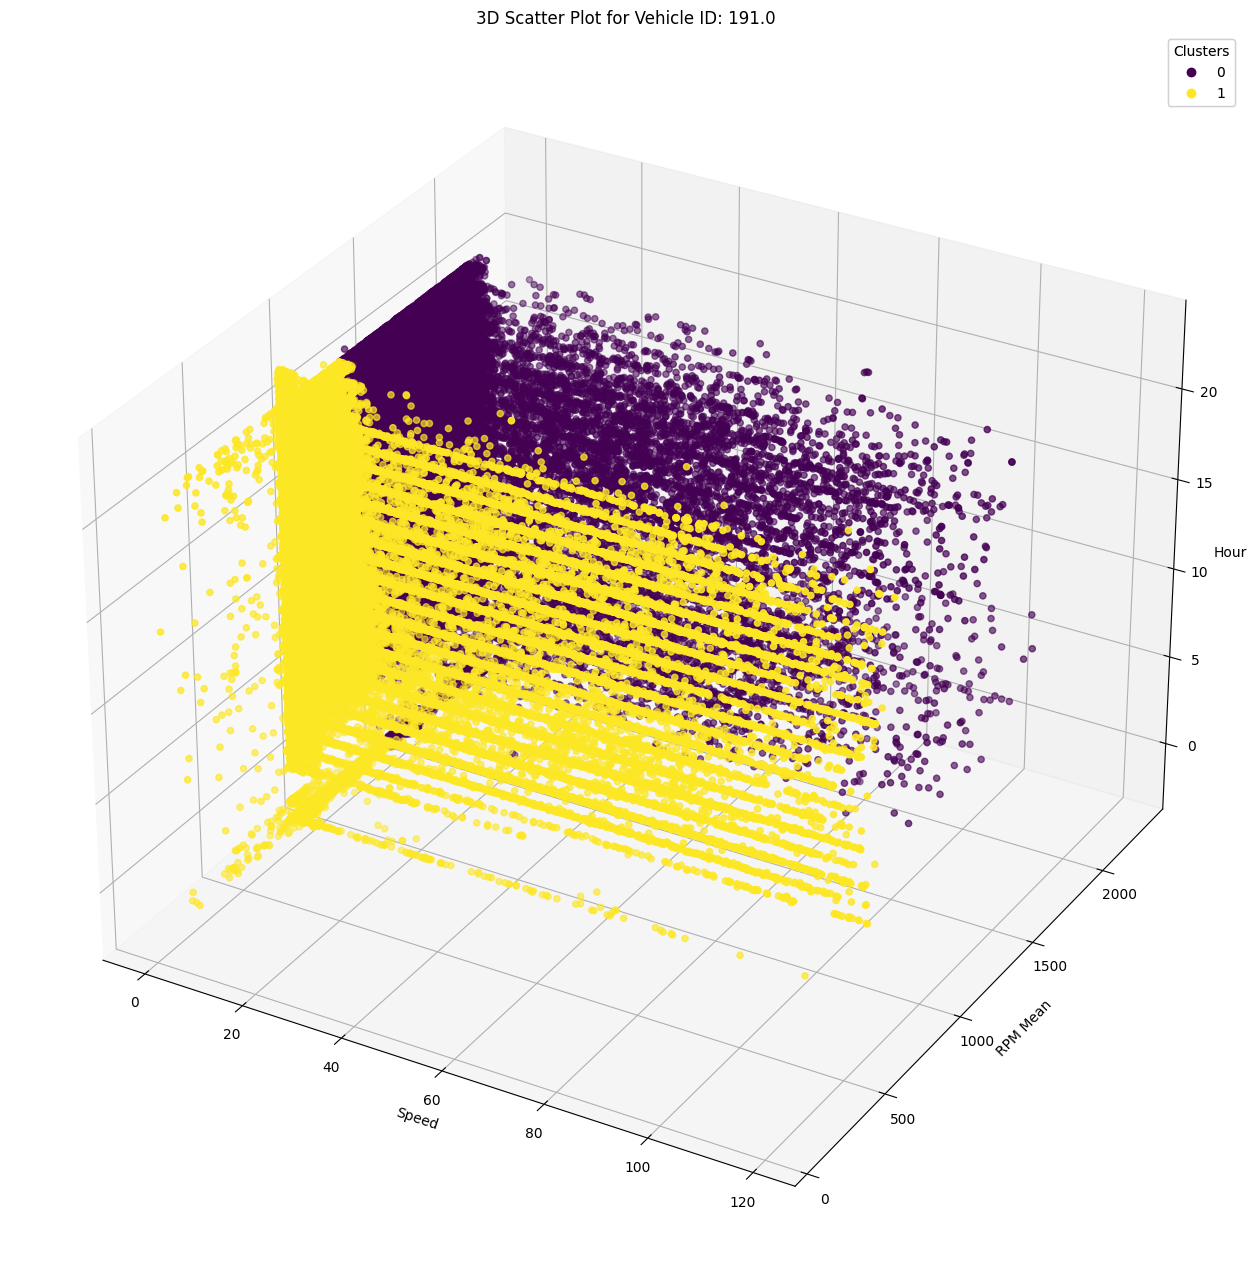

In [13]:
veh_id_to_plot = data['mapped_veh_id'].unique()[2]
data_to_plot = data[data['mapped_veh_id'] == veh_id_to_plot]

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_to_plot['Speed'], data_to_plot['RPM_Mean'], data_to_plot['hour'], 
                     c=data_to_plot['cluster'], cmap='viridis', depthshade=True)

legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)

ax.set_xlabel('Speed')
ax.set_ylabel('RPM Mean')
ax.set_zlabel('Hour')

ax.set_title('3D Scatter Plot for Vehicle ID: {}'.format(veh_id_to_plot))

plt.show()

# Save to CSV

In [14]:
data = data.drop(['RPM_Mean'], axis=1)

In [15]:
data.to_csv('labeled_augumented_cleaned_ar41_for_ulb.csv', index=True)